In [17]:
import numpy as np
np.testing.Tester = np.testing.TestCase
import pandas as pd
import json
import scipy
import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from feos.si import * # SI numbers and constants
from feos.pcsaft import *
from feos.eos import *

from eyring_entropy import *

msize=12
mwidth = 2
fsize=16
alpha=0.3
lsize = 2
framewidth = 3
markeredgewidth=3
markeredgewidth_no=10

In [18]:
"""
choose specie, parameter-source and path
"""

saft_paras = "20191105_pure_parameters_feos.json"

name = "butanol"
#name = "propanol"

#name = "hexane"
name = "water"

savepath = "results_diffusion/"


In [19]:
"""
build path to save results
"""
try:
    os.mkdir(savepath)
except:
    None

try:
    os.mkdir(savepath+"/"+name)
except:
    None

'water'

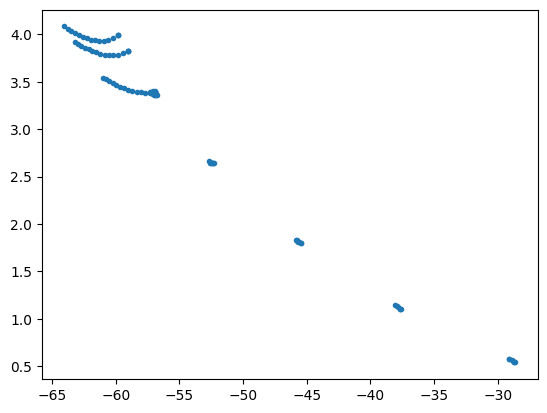

In [ ]:
"""
load and process data

"""

parameters = PcSaftParameters.from_json(
    [name.split("_")[0]], 
    saft_paras, 
    #search_option="name"
)

M = parameters.pure_records[0].molarweight *(GRAM/MOL)
m = parameters.pure_records[0].model_record.m

ppath = "experimental/"+name+"/"+name+"_viscosity_proc.csv"
if os.path.exists(ppath):
    data = pd.read_csv(ppath)
else:
    print("no processed data exists. Utilize calc_stuff(x,parameters) from eyring_entropy.py ")

#plt.plot( data["temperature"], np.log(data["pressure"]), "." )
plt.plot( data["s_res"], np.log(data["viscosity"]/data["eta_CE"]), "." )
name

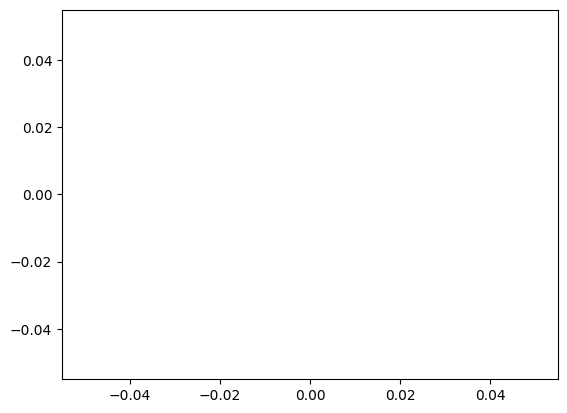

In [ ]:

ppath = "experimental/"+name+"/"+name+"_diffusion.csv"

if os.path.exists(ppath):
    diff_dat = pd.read_csv(ppath)
else:
    print("no processed data exists. Utilize calc_stuff(x,parameters) from eyring_entropy.py ")


plt.plot( diff_dat["s_res"], np.log(diff_dat["D"]), "." )


water & x & 278.15 & 571.1 & 1.0 & 1808.0 & 7.45 & 3.44\\


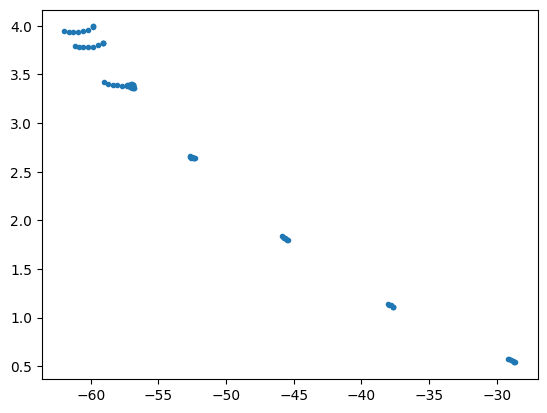

In [22]:
"""
exclude:

- not converged state points
- state points above the pressure limit

"""
eos = EquationOfState.pcsaft(parameters)

critical_point = State.critical_point(eos)

T_crit = critical_point.temperature / KELVIN
rho_crit = critical_point.density *(METER**3/MOL)
V_crit = 1/rho_crit
V_crit

data = data[  data["s_res"] < -0.1  ] # exclude not converged (iG) datapoints
dummy = data[  data["s_res"] < -8  ] # exclude not converged (iG) datapoints
#dummy = data[  data["s_res"] > -120  ]
dummy = dummy[  dummy["pressure"] < 2e8  ]
dummy = dummy[dummy["state"]=="L"]
dummy = dummy[dummy["temperature"]<0.9*T_crit]

if name=="propanol":
    dummy = dummy[  dummy["s_res"] < -50  ]

plt.plot( dummy["s_res"], np.log(dummy["viscosity"]/dummy["eta_CE"]), "." )


maxs = dummy.max(axis=0)
mins = dummy.min(axis=0)
mima = [ str(round(mins["temperature"],2)), str(round(maxs["temperature"],2)),
         str(round(mins["pressure"]/1e5,2)), str(round(maxs["pressure"]/1e5,2)),
         str(round( -mins["s_res"]/8.314,2)), str(round(-maxs["s_res"]/8.314,2))
       ]
print( name+" & x & "+" & ".join(mima) +"\\\\"  )

In [23]:
"""

Choose and train Eyring model

Model overview:

EyringEntropyModel: EES1 with diffusion
EyringEntropyModel_EES1: EES1 without diffusion
EyringEntropyModel_EES0: EES0 with diffusion

"""

if name == "nonane":
    model = EyringEntropyModel(parameters, dummy, p=[ 4, 0.0, 1.0, .1, .1],data_diffusion=diff_dat)
    print("nonane")
elif name == "butane":
    model = EyringEntropyModel(parameters, dummy, p=[ 3, 0.0, 1.0, .1, .1],data_diffusion=diff_dat)
    print("butane")  
elif name == "hexane":
    model = EyringEntropyModel(parameters, dummy, p=[ 3, 0.0, 1.0, .1, .1],data_diffusion=diff_dat)
    print("hexane")        
else:
    model = EyringEntropyModel(parameters, dummy, p=[ 3, 0.0, 1.0, .1, .1],data_diffusion=diff_dat)

model.train()

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2884627.1970221596
        x: [ 3.290e+00 -5.737e-01  2.478e-01 -1.372e-01  1.521e-02]
      nit: 66
      jac: [-6.781e+05  1.225e+06  4.505e+05  1.811e+06  5.275e+06]
     nfev: 744
     njev: 124
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>

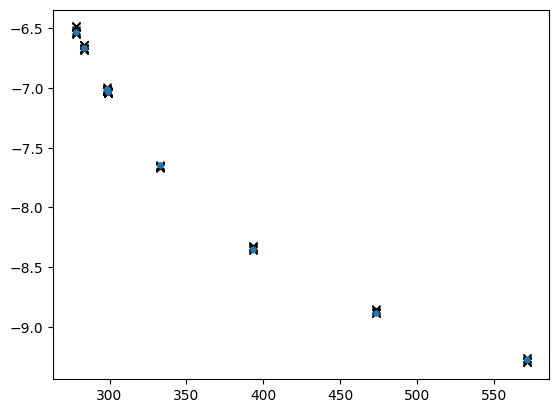

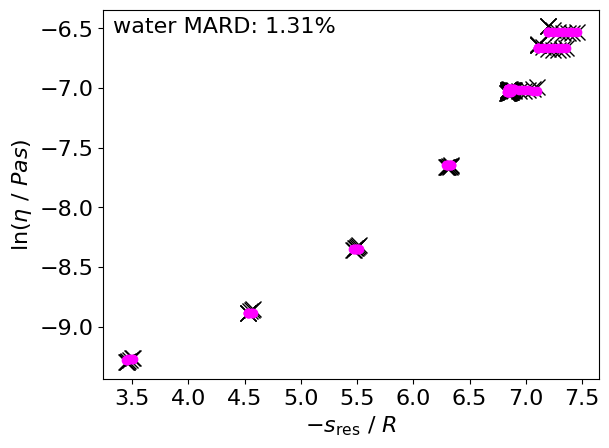

np.float64(1.3112039954317518)

In [24]:
"""
predict and show results plus error

"""

y_pred = model.predict()

plt.plot(model.data["temperature"],np.log(model.data["viscosity"]),"kx")
plt.plot(model.data["temperature"],y_pred,".")
plt.show()
plt.close()

fig, ax = plt.subplots()

plt.plot(-model.data["s_res"]/8.314,np.log(model.data["viscosity"]),"kx",markersize=msize)
plt.plot(-model.data["s_res"]/8.314,y_pred,".",color="magenta",markersize=msize)

plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(\eta~/~Pas)$",fontsize=fsize)

error = np.mean(np.abs( ( np.exp(y_pred) - model.data["viscosity"]) / model.data["viscosity"] ))*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  


plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy.pdf",bbox_inches='tight')

plt.show()
plt.close()  


error

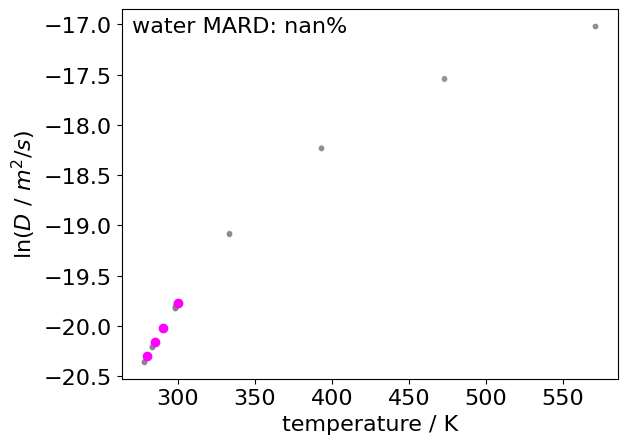

nan

In [25]:
"""
predict diffusion

NOTE: leads to error if diffusion is not implemented ;) Then skip...
"""

y_pred = model.predict_diffusion()
y_pred_D = model.predict_diffusion(data = diff_dat)

fig, ax = plt.subplots()

plt.plot(diff_dat["temperature"], np.log(diff_dat["D"]),"kx",markersize=msize)
plt.plot(model.data["temperature"],y_pred,".",color="grey",alpha=0.2)
plt.plot(diff_dat["temperature"],y_pred_D,".",color="magenta",markersize=msize)

plt.xlabel(r"temperature / K",fontsize=fsize)
plt.ylabel(r"$\ln(D~/~m^2/s)$",fontsize=fsize)

error = np.mean(np.abs( ( np.exp(y_pred_D) - diff_dat["D"]) / diff_dat["D"] ))
error = error*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion.pdf",bbox_inches='tight')


plt.show()
plt.close()

error

In [26]:
model.p

array([ 3.29008641, -0.57365131,  0.24784286, -0.13721895,  0.01520713])

In [27]:
model.train_diffusion()

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 0.0
        x: [ 1.667e-01]
      nit: 0
      jac: [ 0.000e+00]
     nfev: 2
     njev: 1
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>

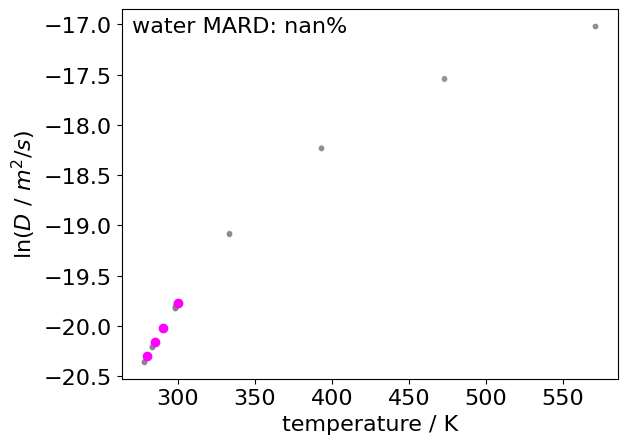

nan

In [28]:
"""
predict diffusion

NOTE: leads to error if diffusion is not implemented ;) Then skip...
"""

y_pred = model.predict_diffusion()
y_pred_D = model.predict_diffusion(data = diff_dat)

fig, ax = plt.subplots()

plt.plot(diff_dat["temperature"], np.log(diff_dat["D"]),"kx",markersize=msize)
plt.plot(model.data["temperature"],y_pred,".",color="grey",alpha=0.2)
plt.plot(diff_dat["temperature"],y_pred_D,".",color="magenta",markersize=msize)

plt.xlabel(r"temperature / K",fontsize=fsize)
plt.ylabel(r"$\ln(D~/~m^2/s)$",fontsize=fsize)

error = np.mean(np.abs( ( np.exp(y_pred_D) - diff_dat["D"]) / diff_dat["D"] ))
error = error*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion_train.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion_train.pdf",bbox_inches='tight')


plt.show()
plt.close()

error

In [29]:
1/model.dd

array([6.])

In [30]:
model.train_both()

  message: ABNORMAL: 
  success: False
   status: 2
      fun: nan
        x: [ 3.290e+00 -5.737e-01  2.478e-01 -1.372e-01  1.521e-02
             1.667e-01]
      nit: 0
      jac: [       nan        nan        nan        nan        nan
                   nan]
     nfev: 147
     njev: 21
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>

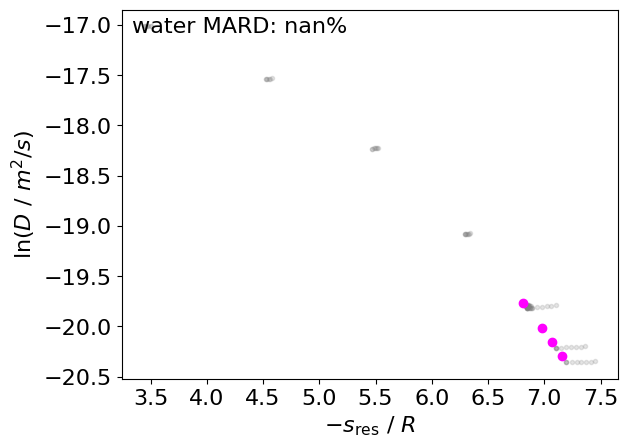

nan

In [31]:
"""
predict diffusion

NOTE: leads to error if diffusion is not implemented ;) Then skip...
"""

y_pred = model.predict_diffusion()
y_pred_D = model.predict_diffusion(data = diff_dat)

fig, ax = plt.subplots()

plt.plot(-diff_dat["s_res"]/8.314, np.log(diff_dat["D"]),"kx",markersize=msize)
plt.plot(-model.data["s_res"]/8.314,y_pred,".",color="grey",alpha=0.2)
plt.plot(-diff_dat["s_res"]/8.314,y_pred_D,".",color="magenta",markersize=msize)

# plt.xlabel(r"temperature / K",fontsize=fsize)
plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(D~/~m^2/s)$",fontsize=fsize)

error = np.mean(np.abs( ( np.exp(y_pred_D) - diff_dat["D"]) / diff_dat["D"] ))
error = error*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  

plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion_both.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_diffusion_both.pdf",bbox_inches='tight')


plt.show()
plt.close()

error

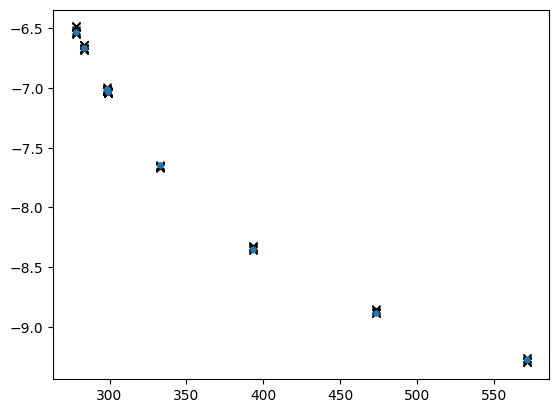

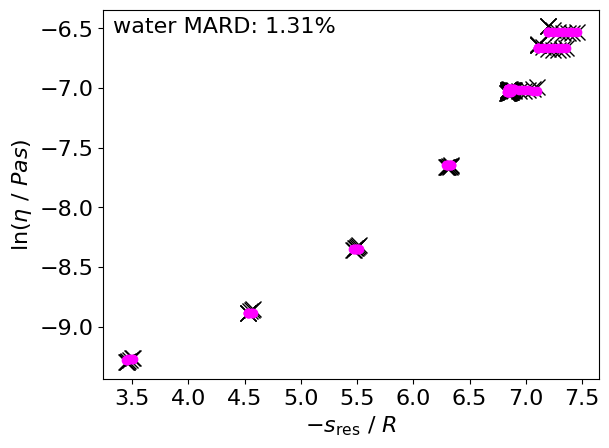

np.float64(1.3112039954317518)

In [32]:
"""
predict and show results plus error

"""

y_pred = model.predict()

plt.plot(model.data["temperature"],np.log(model.data["viscosity"]),"kx")
plt.plot(model.data["temperature"],y_pred,".")
plt.show()
plt.close()

fig, ax = plt.subplots()

plt.plot(-model.data["s_res"]/8.314,np.log(model.data["viscosity"]),"kx",markersize=msize)
plt.plot(-model.data["s_res"]/8.314,y_pred,".",color="magenta",markersize=msize)

plt.xlabel(r"$-s_\text{res}~/~R$",fontsize=fsize)
plt.ylabel(r"$\ln(\eta~/~Pas)$",fontsize=fsize)

error = np.mean(np.abs( ( np.exp(y_pred) - model.data["viscosity"]) / model.data["viscosity"] ))*100

plt.text(0.02, 0.98, name.split("_")[0]+' MARD: '+str(round(error,2))+"%",
     fontsize=fsize,
     horizontalalignment='left',
     verticalalignment='top',
     transform = ax.transAxes)

plt.xticks(fontsize=fsize)  
plt.yticks(fontsize=fsize)  


plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_both.png",bbox_inches='tight')
plt.savefig(savepath+"/"+name+"/"+name+"_eyring_entropy_both.pdf",bbox_inches='tight')

plt.show()
plt.close()  

error